## Import libraries and define the Dataset

### Required Libraries

In [1]:
import folium
import glob
import functools

import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
import reverse_geocoder as rg
import plotly.express as px

from global_land_mask import globe
from folium.plugins import HeatMap
from PIL import Image

from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon

from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE, BORDERS
import cartopy.feature as cfeature  
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Read in the data from the hurdat.csv
Data from hurdat.csv has already been rearranged via script so that it can be read as a dataframe more easily.

In [2]:
# Used globally by some of the various helper functions
hurdat = pd.read_csv('../Data/hurdat.csv', parse_dates=['Time'])
hurdat.sample(10)

Code       Name      Date  Time Record Identifier Storm Status  \
34742  AL131981      EMILY  19810907  0000               NaN           HU   
33833  AL111979   FREDERIC  19790905  0000               NaN           TS   
6922   AL041892    UNNAMED  18920909  0600               NaN           TS   
10238  AL031903    UNNAMED  19030910  0000               NaN           TS   
9469   AL051900    UNNAMED  19001011  0000               NaN           EX   
51656  AL132019    LORENZO  20190925  1800               NaN           HU   
49024  AL042014  CRISTOBAL  20140827  1200               NaN           HU   
17421  AL171933    UNNAMED  19331005  1200               NaN           HU   
15546  AL081927    UNNAMED  19271119  1200               NaN           TS   
46251  AL102008  JOSEPHINE  20080908  1200               NaN           LO   

      Latitude Longitude  Max Sustained Wind Speed  Minumum Pressure  ...  \
34742    41.6N     56.8W                        75               972  ...   
33833    18.0N     67.8W                        45              1006  ...   
6922     23.4N     93.7W                        35              -999  ...   
10238    22.6N     74.7W                        55              -999  ...   
9469     41.2N     68.5W                        40              -999  ...   
51656    14.4N     36.0W                        80               979  ...   
49024    31.6N     72.2W                        70               983  ...   
17421    24.8N     79.7W                       100              -999  ...   
15546    23.5N     52.0W                        35              -999  ...   
46251    18.0N     44.2W                        25              1009  ...   

       34 KT Wind Radii Max SW  34 KT Wind Radii Max NW  \
34742                     -999                     -999   
33833                     -999                     -999   
6922                      -999                     -999   
10238                     -999                     -999   
9469                      -999                     -999   
51656                       50                      170   
49024                       60                      100   
17421                     -999                     -999   
15546                     -999                     -999   
46251                        0                        0   

       50 KT Wind Radii Max NE  50 KT Wind Radii Max SE  \
34742                     -999                     -999   
33833                     -999                     -999   
6922                      -999                     -999   
10238                     -999                     -999   
9469                      -999                     -999   
51656                       80                       20   
49024                       90                      100   
17421                     -999                     -999   
15546                     -999                     -999   
46251                        0                        0   

       50 KT Wind Radii Max SW  50 KT Wind Radii Max NW  \
34742                     -999                     -999   
33833                     -999                     -999   
6922                      -999                     -999   
10238                     -999                     -999   
9469                      -999                     -999   
51656                       20                       80   
49024                       20                       20   
17421                     -999                     -999   
15546                     -999                     -999   
46251                        0                        0   

       64 KT Wind Radii Max NE  64 KT Wind Radii Max SE  \
34742                     -999                     -999   
33833                     -999                     -999   
6922                      -999                     -999   
10238                     -999                     -999   
9469                      -999                     -999   
51656      

## Define various helper functions

### Create functions that allow for easier plotting

In [3]:
# This uses the hurdat by default for convenience and readability later on
def plot_storm(code, axis, storm=hurdat, **kwargs):
    '''Plot a storm's track given a code and a matplotlib axis. Defaults to using the global hurdat dataframe.'''
    
    storm = storm[(storm['Code'] == code)]
    axis.plot(storm['Longitude'], storm['Latitude'],  **kwargs)

In [4]:
def plot_shape(row, axis, shapes=['34 KT Shape', '50 KT Shape', '64 KT Shape'], 
               colors=['green', 'yellow', 'red'], **kwargs):
    ''' Plot the 34 KT, 50 KT, and 64 KT shapes for a given row on the provided axis'''

    zorder = 3
    
    for shape, color in zip(shapes, colors):
        shape = row[shape]
    
        if not(pd.isna(shape) or shape.is_empty):
            x, y = shape.exterior.xy
            axis.fill(x, y, color=color, zorder=zorder, **kwargs);
        
        zorder += 1

### Create functions that allow for easier information look-up

In [5]:
def get_code(name, year):
    '''Returns a storm code given a name and a year'''
    return hurdat[(hurdat['Name'].str.lower() == name.lower()) & (hurdat['Date'].dt.year == year)]['Code'].unique()[0]

In [6]:
def get_name(code):
    '''Returns a storm name given a code'''
    return hurdat[(hurdat['Code'] == code)]['Name'].unique()[0].title()

In [7]:
def get_year(code):
    '''Returns a storm year given a code'''
    return hurdat[(hurdat['Code'] == code)]['Date'].dt.year.unique()[0]

In [8]:
def get_label(code):
    '''Returns name, year as a string for a storm given a code'''
    return  get_name(code) + ', ' + str(get_year(code))

### Create functions for cleaning or building new data

In [9]:
def convert_coord(lat, long):
    '''Takes a string tuple for lattitude and longitude and returns the corresponding float tuple'''
    
    latitude, longitude = float(lat[:-1]), float(long[:-1])
    
    if lat[-1] == 'S': latitude *= -1
    if long[-1] == 'W': longitude *= -1
        
    return latitude, longitude

In [10]:
def get_quadrant(center, radius, zone):
    '''Creates a quarter of a circle based off of a given wind radii and adjusts it based on
       on the center of the storm'''
    
    conversion_map = {'NE':(1,1), 'SE':(1,-1), 'SW':(-1,-1), 'NW':(-1,1)}
    conv = conversion_map[zone]
    
    # convert radius (which is in nautical miles) to be on the same scale as longitude and latitude
    radius /= 60

    circle = Point(center[0], center[1]).buffer(radius)

    boundary = Polygon([(center[0], center[1]),
                        (radius * conv[0] + center[0], center[1]),
                        (radius * conv[0] + center[0], radius * conv[1] + center[1]),
                        (center[0], radius * conv[1] + center[1])])

    return circle.intersection(boundary)

In [11]:
def build_shape(row):
    '''Builds a shape of the a storm with its wind radii information one fourth at a time
       and then combines them into one shape that represents the size of the storm'''
    
    # Return nan if any inputs are nan
    if row.isna().any():
        return np.nan
    
    long, lat, radius_ne, radius_se, radius_sw, radius_nw = row
    zones = ['NE', 'SE', 'SW', 'NW']
    radii = [radius_ne, radius_se, radius_sw, radius_nw]
    center = [long, lat]
    quadrants = []

    for zone, radius in zip(zones, radii):
        quadrants.append(get_quadrant(center, radius, zone))
    
    return functools.reduce(Polygon.union, quadrants)

In [12]:
def png_to_gif(path, save_path, duration = 500):
    frames = []
    
    images = glob.glob(f'{path}')
    
    for i in sorted(images):
        im = Image.open(i)
        im = im.resize((550,389), Image.ANTIALIAS)
        frames.append(im.copy())
        
    frames[0].save(f'{save_path}', format = 'GIF', append_images = frames[1:], save_all = True,
                  duration = duration, loop = 0)

In [13]:
def quadgraph(quad, storm, quadstring,color):
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, alpha=0.85, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title('Paths of '+ storm +' in '+ quadstring, fontsize = 25)
    for code in quad['Code'].unique():
        plot_storm(code, ax, alpha = 0.3,color=color)

## Clean the dataset

### Combine date and time columns into a single timestamp variable called 'Date'

In [14]:
# combine the date and time columns into a single date column and drop time
hurdat['Date'] = pd.to_datetime(hurdat['Date'].astype(str) + hurdat['Time'])
hurdat.drop(['Time'], axis=1, inplace=True)

### Add size variables to the set based on wind radii values

In [15]:
# Turn encoded missing values into actual missing values
hurdat.mask(hurdat == -999, np.nan, inplace=True)

# create a 34 KT size variable for each observation
hurdat['34 KT Size'] = (hurdat['34 KT Wind Radii Max NE'].values**2 * np.pi / 4 + \
                        hurdat['34 KT Wind Radii Max SE'].values**2 * np.pi / 4 + \
                        hurdat['34 KT Wind Radii Max SW'].values**2 * np.pi / 4 + \
                        hurdat['34 KT Wind Radii Max NW'].values**2 * np.pi / 4).round(2)

# create a 50 KT size variable for each observation
hurdat['50 KT Size'] = (hurdat['50 KT Wind Radii Max NE'].values**2 * np.pi / 4 + \
                        hurdat['50 KT Wind Radii Max SE'].values**2 * np.pi / 4 + \
                        hurdat['50 KT Wind Radii Max SW'].values**2 * np.pi / 4 + \
                        hurdat['50 KT Wind Radii Max NW'].values**2 * np.pi / 4).round(2)

# create a 34 KT size variable for each observation
hurdat['64 KT Size'] = (hurdat['64 KT Wind Radii Max NE'].values**2 * np.pi / 4 + \
                        hurdat['64 KT Wind Radii Max SE'].values**2 * np.pi / 4 + \
                        hurdat['64 KT Wind Radii Max SW'].values**2 * np.pi / 4 + \
                        hurdat['64 KT Wind Radii Max NW'].values**2 * np.pi / 4).round(2)

### Create a 'Time Since Formation' variable

In [16]:
hurdat['Time Since Formation'] = hurdat['Date'] - hurdat.groupby('Code')['Date'].transform(np.min)

### Convert latitude and longitude into numeric values

In [17]:
coordinates = zip(hurdat['Latitude'].values, hurdat['Longitude'].values)
track = []

for coordinate in coordinates:
    track.append(convert_coord(*coordinate))

lat, long = zip(*track)

hurdat['Latitude'] = lat
hurdat['Longitude'] = long

### Build shapes for each wind speed size

In [18]:
hurdat['34 KT Shape'] = hurdat[['Longitude', 'Latitude', 
                                '34 KT Wind Radii Max NE',
                                '34 KT Wind Radii Max SE',
                                '34 KT Wind Radii Max SW',
                                '34 KT Wind Radii Max NW']].apply(build_shape, axis=1)

hurdat['50 KT Shape'] = hurdat[['Longitude', 'Latitude', 
                                '50 KT Wind Radii Max NE',
                                '50 KT Wind Radii Max SE',
                                '50 KT Wind Radii Max SW',
                                '50 KT Wind Radii Max NW']].apply(build_shape, axis=1)

hurdat['64 KT Shape'] = hurdat[['Longitude', 'Latitude', 
                                '64 KT Wind Radii Max NE',
                                '64 KT Wind Radii Max SE',
                                '64 KT Wind Radii Max SW',
                                '64 KT Wind Radii Max NW']].apply(build_shape, axis=1)

### Create storm categories based on wind speed

In [19]:
hurdat['Category'] = pd.cut(hurdat['Max Sustained Wind Speed'], [0,64,83,96,113,137,np.inf], 
                              labels=[0,1,2,3,4,5])

### Split storms into decades

In [20]:
hurdat['Decade'] = pd.cut(hurdat['Date'].dt.year, range(1850, 2030, 10))

### Flag hurricanes and storms that became major storms (category 3 or geater)
Placing these flags now makes grouping for various graphs easier later

In [21]:
hurdat['Major Storm'] = hurdat.groupby('Code')['Category'].transform(np.max) >= 3
hurdat['Hurricane'] = hurdat.groupby('Code')['Category'].transform(np.max) >= 1

### Add Year, Month, and Day columns for easier grouping

In [22]:
hurdat['Year'] = hurdat['Date'].dt.year
hurdat['Month'] = hurdat['Date'].dt.month
hurdat['Day'] = hurdat['Date'].dt.day

### Add a column for if the storm is currently over land

In [23]:
hurdat['Landfall'] = pd.Series(globe.is_land(hurdat['Latitude'], hurdat['Longitude']))

### Add a column for the nearest state

In [24]:
coor = list(zip(hurdat['Latitude'],hurdat['Longitude']))
info = rg.search(coor)
state = pd.DataFrame(map(lambda x: x['admin1'],info),columns = ['State'])

Loading formatted geocoded file...


In [25]:
hurdat = pd.concat([hurdat,state], axis = 1)

In [26]:
hurdat['State'].unique()

array(['Texas', 'Veracruz', 'Eastern Tobago', 'Guyane', 'Saint Philip',
       'Saint Joseph', '', 'Saint Anthony', 'Saint Croix Island',
       'Arroyo', 'Cabo Rojo', 'San Pedro de Macoris', 'Barahona',
       'Artibonite', 'Grandans', 'Santiago de Cuba', 'Las Tunas',
       'Camaguey', 'Cienfuegos', 'Matanzas', 'La Habana', 'Artemisa',
       'Pinar del Rio', 'Florida', 'Georgia', 'South Carolina',
       'North Carolina', 'Virginia', 'Maryland', 'New York',
       'Massachusetts', 'Nova Scotia', 'Miquelon-Langlade',
       'Newfoundland and Labrador', 'North Abaco', 'Isabela', 'Samana',
       'Maria Trinidad Sanchez', 'Mayaguana', 'Acklins', 'Ragged Island',
       'Ciego de Avila', 'Villa Clara', 'Alabama', 'Mississippi',
       'Guayama', 'Mayaguez', 'La Altagracia', 'Duarte',
       'Santiago Rodriguez', 'Nord', 'Louisiana', 'Saint Peter',
       'Barbuda', 'Saint Thomas Island', 'Loiza', 'Arecibo', 'Aguadilla',
       'San Juan', 'Puerto Plata', 'Monte Cristi', 'Inagua',
      

## Plotting Tracks

### Plot the track for hurricane Florence

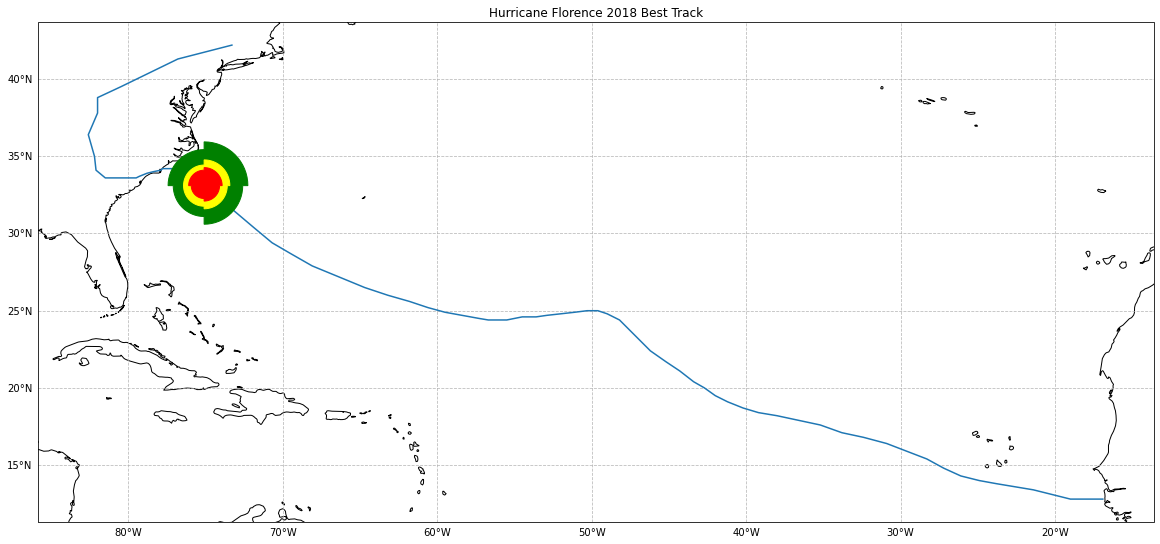

In [27]:
#plt.rcParams["figure.figsize"] = (20,20)
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(draw_labels=True, alpha=0.85, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Hurricane Florence 2018 Best Track')
plot_storm(get_code('Florence', 2018), ax)

florence = hurdat[hurdat['Code'] == get_code('Florence', 2018)]
florence = florence.sort_values('34 KT Size', ascending = False)
plot_shape(florence.iloc[0], ax)

### Create animations for the hurricane path
Change the cell type to code and only run this when you want to create the several image files required for creating a gif. This method allowed for more control in the final animation than using matplotlib's animate method.

### Plot the tracks for all hurricanes since 1851

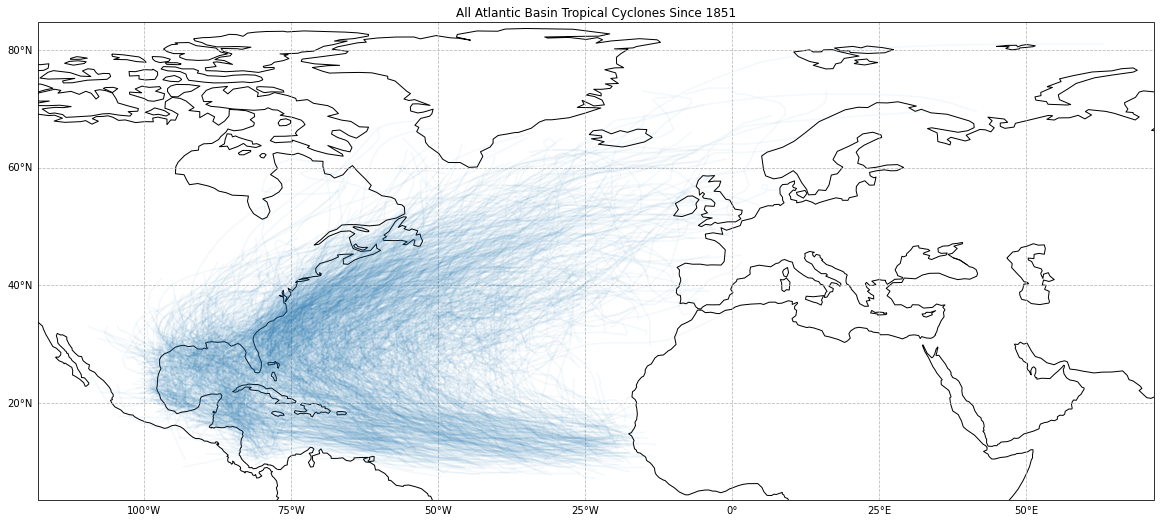

In [28]:
# Takes a minute to run
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(draw_labels=True, alpha=0.85, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('All Atlantic Basin Tropical Cyclones Since 1851')
    
for code in hurdat['Code'].unique():
    plot_storm(code, ax, alpha=0.05, color='#1f77b4')


### Hurricane Winds on Land

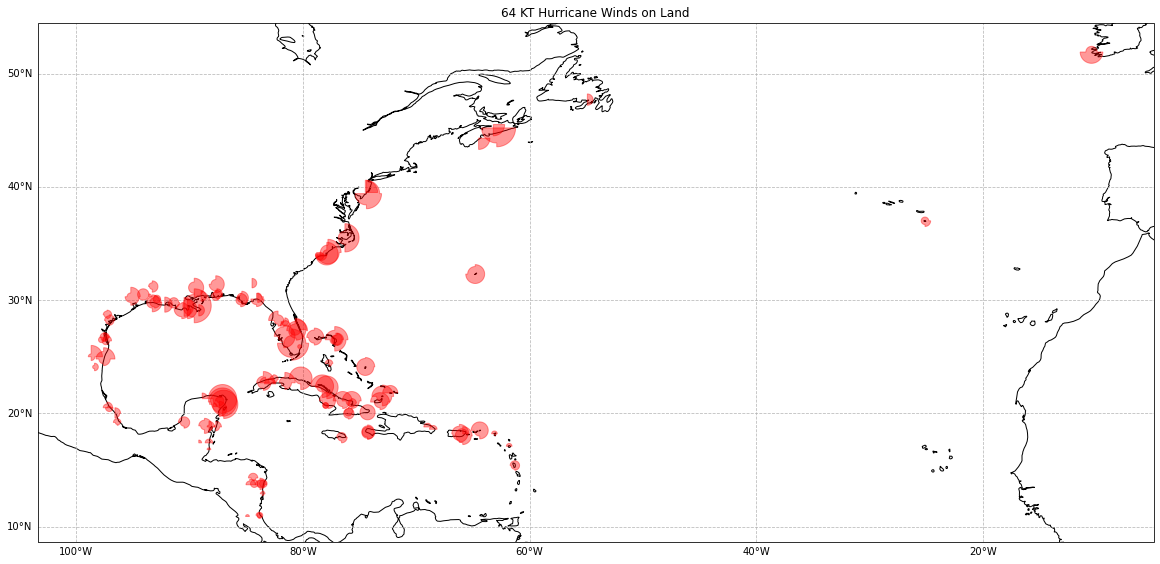

In [29]:
# Takes a minute to run
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(draw_labels=True, alpha=0.85, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('64 KT Hurricane Winds on Land')

landfall = hurdat[hurdat['Landfall']]
for i, row in landfall.iterrows():
    plot_shape(row, ax, shapes=['64 KT Shape'], colors=['Red'], alpha=0.4)

## Plot the top hurricanes

### Plot the the top ten hurricanes by wind speed

In [30]:
top_ten = hurdat.sort_values('Max Sustained Wind Speed', ascending=False)['Code'].unique()[:10]
wind_speeds = []
for code in top_ten:
    wind_speeds.append(hurdat[hurdat['Code'] == code]['Max Sustained Wind Speed'].sort_values(ascending=False).to_numpy()[0])

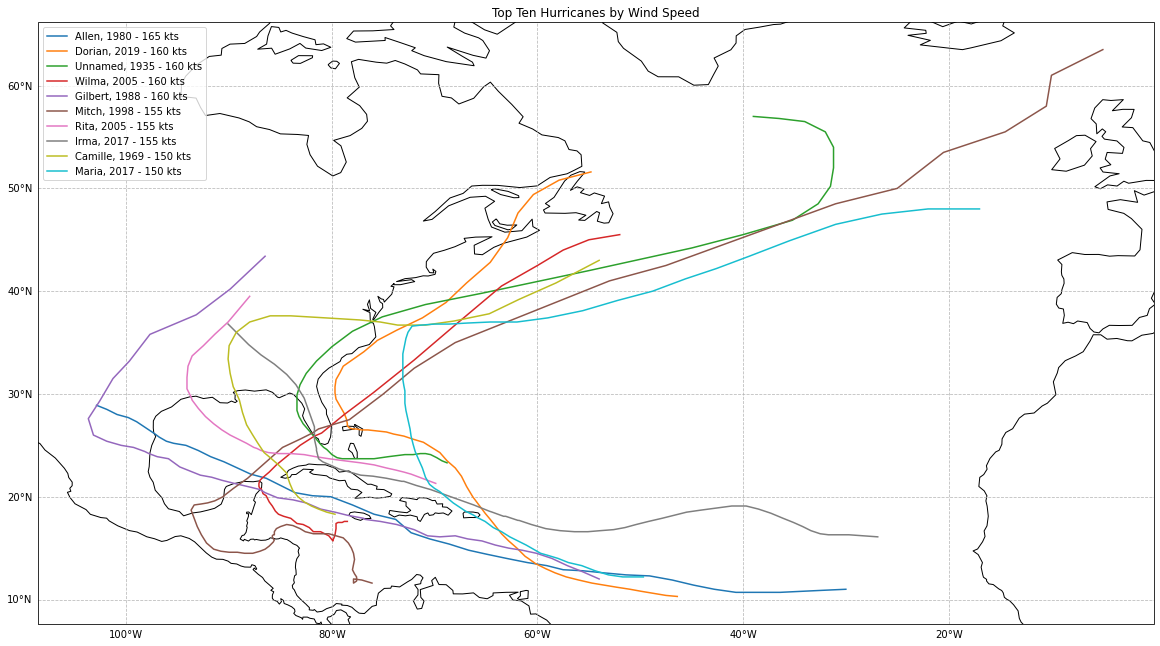

In [31]:
plt.rcParams["figure.figsize"] = (20,20)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(draw_labels=True, alpha=0.85, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Top Ten Hurricanes by Wind Speed')
    
for code, wind_speed in zip(top_ten, wind_speeds):
    label = get_label(code) + ' - ' + str(wind_speed) + ' kts'
    plot_storm(code, ax, label=label)
    
ax.legend()
plt.show()

## Plotting wind speed and size

### Plot wind speed and size for Florence

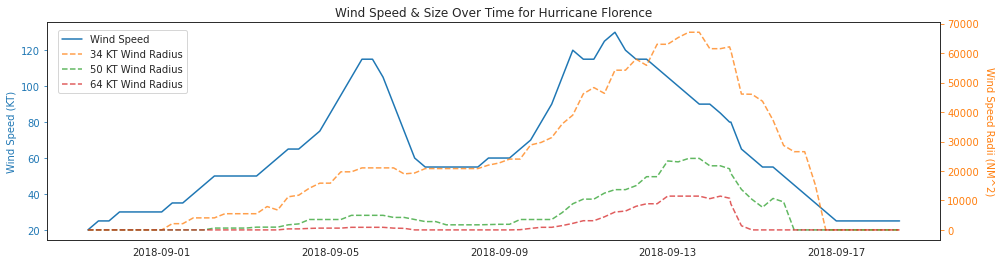

In [32]:
sns.set_style('white')

storm = hurdat[hurdat['Code'] == get_code('Florence', 2018)]
fig, ax = plt.subplots(figsize=(16,4))
ax2 = ax.twinx()

ax.plot(storm['Date'], storm['Max Sustained Wind Speed'], '#1f77b4', label='Wind Speed')
ax2.plot(storm['Date'], storm['34 KT Size'], '#ff7f0e', alpha= 0.75, label='34 KT Wind Radius', linestyle='--')
ax2.plot(storm['Date'], storm['50 KT Size'], '#2ca02c', alpha= 0.75, label='50 KT Wind Radius', linestyle='--')
ax2.plot(storm['Date'], storm['64 KT Size'], '#d62728', alpha= 0.75, label='64 KT Wind Radius', linestyle='--')

ax.tick_params('y', colors='#1f77b4')
ax2.tick_params('y', colors='#ff7f0e')

ax.set_ylabel('Wind Speed (KT)', color='#1f77b4')
ax2.set_ylabel('Wind Speed Radii (NM^2)', color='#ff7f0e', rotation=270, labelpad=15)

fig.legend(loc='upper left', bbox_to_anchor=(0.13, 0.87))
ax.set_title('Wind Speed & Size Over Time for Hurricane Florence')
plt.show()

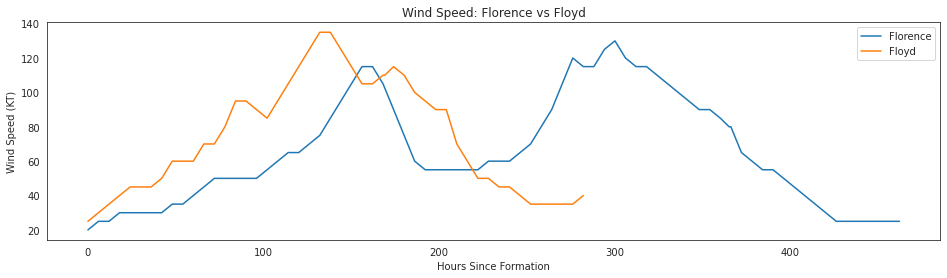

In [33]:
storm = hurdat[hurdat['Code'] == get_code('Florence', 2018)]
storm2 = hurdat[hurdat['Code'] == get_code('Floyd', 1999)]

fig, ax = plt.subplots(figsize=(16,4))

ax.plot(storm['Time Since Formation'].astype('timedelta64[h]'), 
        storm['Max Sustained Wind Speed'], label='Florence')

ax.plot(storm2['Time Since Formation'].astype('timedelta64[h]'), 
        storm2['Max Sustained Wind Speed'], label='Floyd')

ax.set_ylabel('Wind Speed (KT)')
ax.set_xlabel('Hours Since Formation')
ax.set_title('Wind Speed: Florence vs Floyd')

ax.legend()
plt.show()

## Plot hurricane activity over the years

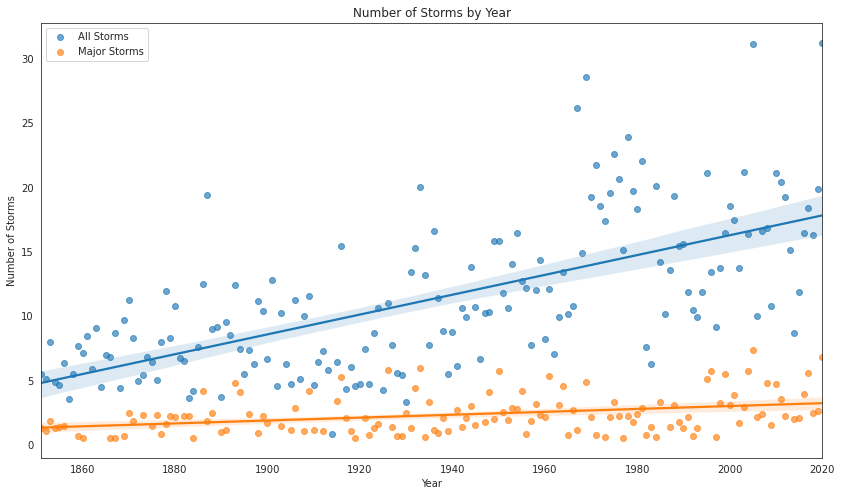

In [34]:
all_storms = hurdat.drop_duplicates('Code').groupby('Year').size()
hurricanes = hurdat[hurdat['Hurricane']].drop_duplicates('Code').groupby('Year').size()
major_storms = hurdat[hurdat['Major Storm']].drop_duplicates('Code').groupby('Year').size()

fig, ax = plt.subplots(figsize=(14,8))
sns.regplot(x=all_storms.index, y=all_storms.values, y_jitter=0.5, 
            label='All Storms', scatter_kws={'alpha':0.65}, ax=ax)
#sns.regplot(x=hurricanes.index, y=hurricanes.values, y_jitter=0.5, 
            #label='Hurricanes', scatter_kws={'alpha':0.65})
sns.regplot(x=major_storms.index, y=major_storms.values, y_jitter=0.5,
            label='Major Storms', scatter_kws={'alpha':0.65}, ax=ax)

ax.set_title('Number of Storms by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Storms')
ax.legend()
plt.show()

### Storm Activity by Month and Day

In [35]:
hurdat = hurdat[hurdat['Year'] >= 1900]

In [36]:
hur_activity = hurdat[(hurdat['Hurricane']) & (hurdat['Year'] >= 1900)][['Code', 'Month', 'Day']] \
                    .groupby(['Month','Day']) \
                    .nunique() \
                    .reset_index()
                
hur_activity['PlotDate'] = pd.to_datetime(hur_activity[['Month', 'Day']].assign(year=2000))

In [37]:
storm_activity = hurdat[['Code', 'Month', 'Day']] \
                    .groupby(['Month','Day']) \
                    .nunique() \
                    .reset_index()

storm_activity['PlotDate'] = pd.to_datetime(storm_activity[['Month', 'Day']].assign(year=2000))

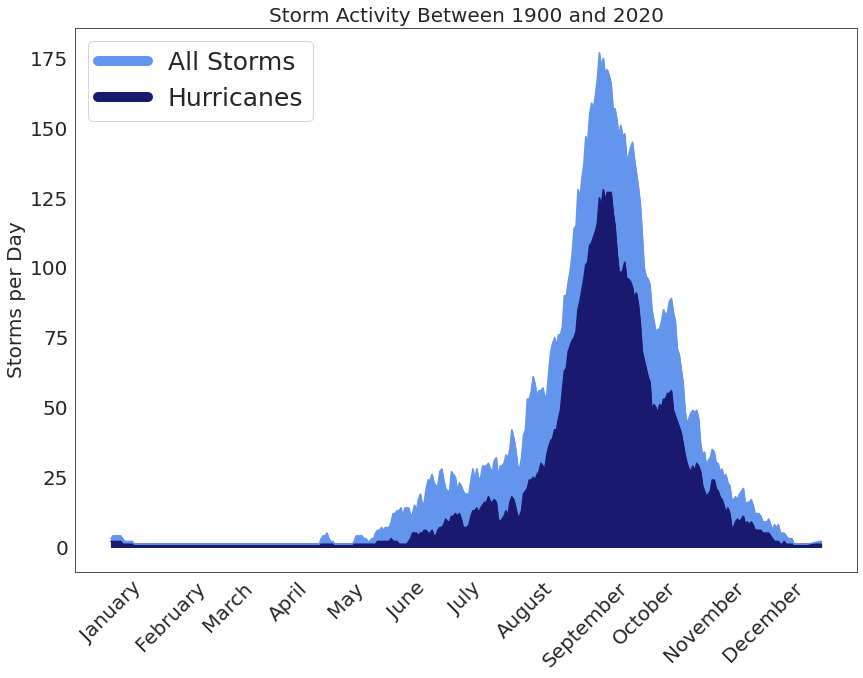

In [38]:
#sns.set_style('white')

year = 2000

plt.figure(figsize = (14,10))
hurs = plt.plot(hur_activity['PlotDate'], hur_activity['Code'], 
                color = 'midnightblue', label = 'Hurricanes')

storms = plt.plot(storm_activity['PlotDate'], storm_activity['Code'],
                  color = 'cornflowerblue', label = 'All Storms')

plt.xticks([f'{year}-01',f'{year}-02',f'{year}-03',f'{year}-04',f'{year}-05',f'{year}-06',
            f'{year}-07',f'{year}-08',f'{year}-09',f'{year}-10',f'{year}-11',f'{year}-12'], 
           ['January', 'February', 'March', 'April','May', 'June',
            'July', 'August', 'September','October','November','December'],
           rotation = 45, fontsize = 20)

# plt.xlabel('Date', fontsize = 25)
plt.ylabel('Storms per Day', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Storm Activity Between 1900 and 2020', fontsize = 20)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='midnightblue', lw=10),
                Line2D([0], [0], color='cornflowerblue', lw=10)]

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([custom_lines[idx] for idx in order],[labels[idx] for idx in order],
          loc = 'upper left', prop = {'size':25}) 

plt.fill_between(storm_activity['PlotDate'], storm_activity['Code'],color = 'cornflowerblue')
plt.fill_between(hur_activity['PlotDate'], hur_activity['Code'],color = 'midnightblue')
plt.show()
#plt.savefig('StormActivity.png')

### Activity by Month

In [39]:
hurcodes = hurdat['Code'][hurdat['Storm Status'] == 'HU']
just_hur = hurdat[hurdat['Code'].isin(hurcodes)]
not_hur = hurdat.loc[~hurdat.Code.isin(just_hur.Code)]

In [40]:
unique_storms = not_hur[['Month','Code']] \
                    .groupby('Month') \
                    .nunique() \
                    .reset_index()
        
unique_hur = just_hur[['Month','Code']]  \
                    .groupby('Month') \
                    .nunique() \
                    .reset_index()

<Figure size 1008x864 with 0 Axes>

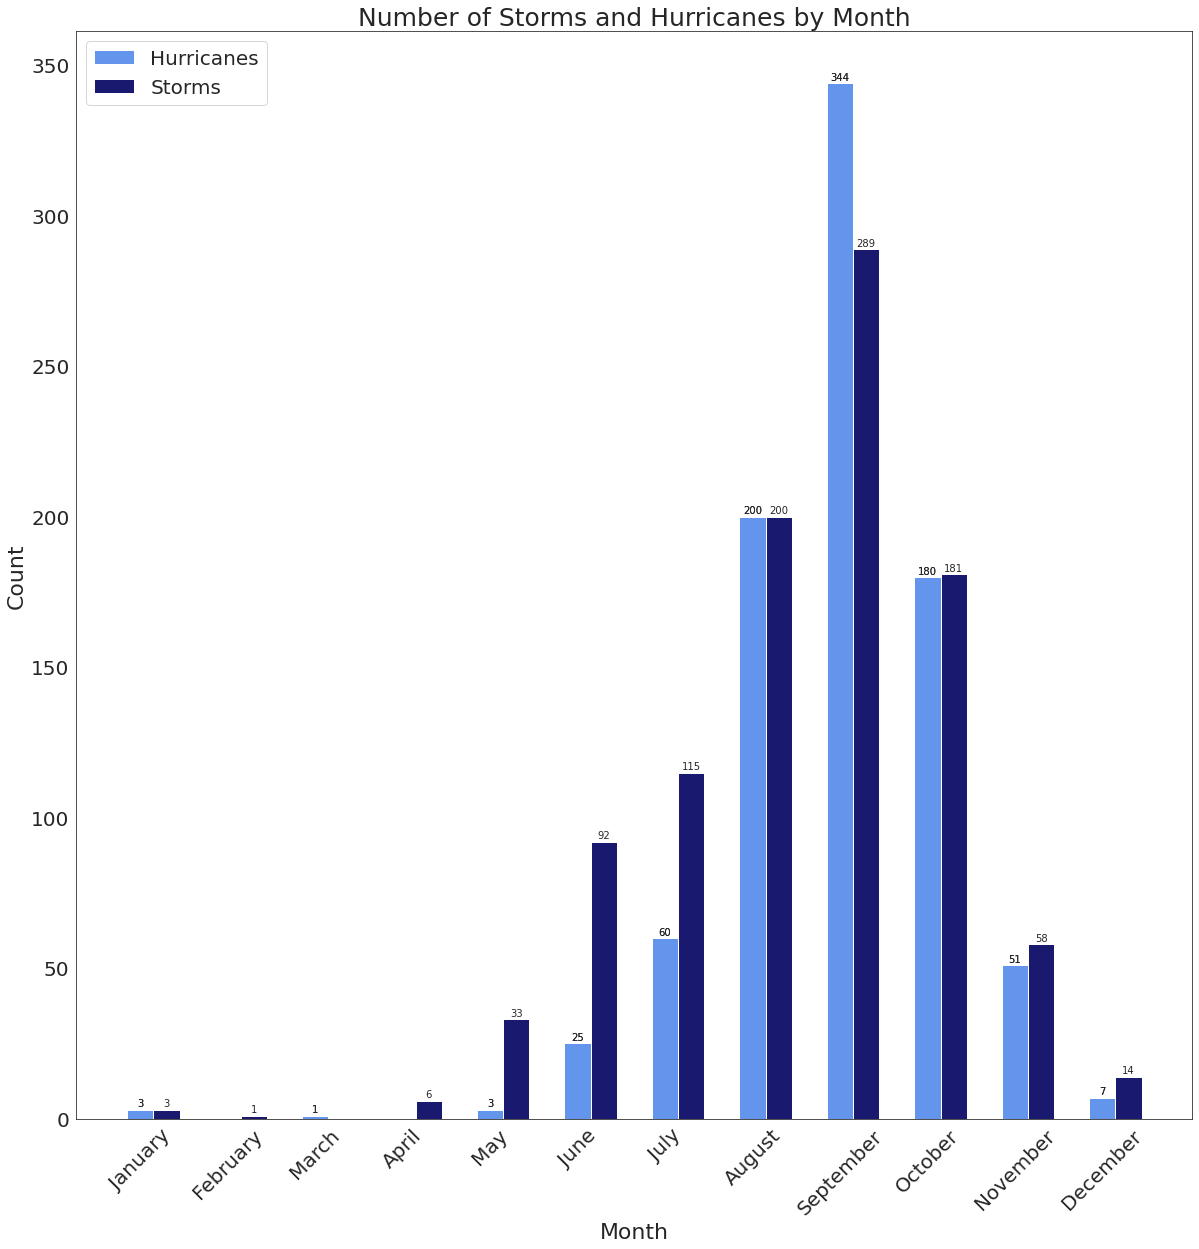

In [41]:
width = 0.3
plt.figure(figsize = (14,12))
fig, ax = plt.subplots()
plt.bar(x = unique_hur['Month'], height = unique_hur['Code'], color = 'cornflowerblue', width = width, label = 'Hurricanes')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.bar(x = unique_storms['Month']+width, height = unique_storms['Code'],color = 'midnightblue',width=width, label = 'Storms')
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.xlabel('Month',fontsize = 22)
plt.xticks([1,2,3,4,5,6,
            7,8,9,10,11,12], 
           ['January', 'February', 'March', 'April','May', 'June',
            'July', 'August', 'September','October','November','December'],rotation = 45,fontsize = 20)
plt.ylabel('Count',fontsize=22)
plt.yticks(fontsize = 20)

plt.title('Number of Storms and Hurricanes by Month', fontsize =25)

plt.legend(loc = 'upper left', prop = {'size':20})
plt.show()

### Heatmap of Storm Activity

In [42]:
January = hurdat[hurdat['Month'] == 1]
February = hurdat[hurdat['Month'] == 2]
March = hurdat[hurdat['Month'] == 3]
April = hurdat[hurdat['Month'] == 4]
May = hurdat[hurdat['Month'] == 5]
June = hurdat[hurdat['Month'] == 6]
July = hurdat[hurdat['Month'] == 7]
August = hurdat[hurdat['Month'] == 8]
September = hurdat[hurdat['Month'] == 9]
October = hurdat[hurdat['Month'] == 10]
November = hurdat[hurdat['Month'] == 11]
December = hurdat[hurdat['Month'] == 12]

In [43]:
def heatmap(month,monthstr):
    month_map = folium.Map([40, -50],zoom_start = 2.5)

    HeatMap(month[['Latitude', 'Longitude']]).add_to(month_map)

    title_html = f'''<h3 align = "center" style = "font-size:20px">
                 <b> {monthstr} Storms </b></h3>'''

    month_map.get_root().html.add_child(folium.Element(title_html))


    #month_map.save(monthstr+'_map_title.html')
    month_map

In [44]:
heatmap(January,'January')
heatmap(February,'February')
heatmap(March,'March')
heatmap(April,'April')
heatmap(May,'May')
heatmap(June,'June')
heatmap(July,'July')
heatmap(August,'August')
heatmap(September,'September')
heatmap(October,'October')
heatmap(November,'November')
heatmap(December,'December')

In [45]:
glob.glob('../dsc502hurdat/*.png')

[]

In [46]:
#png_to_gif(path = '*.png', save_path = '../Data/month_heatmap.gif')

## Analyze Landfall Storms

In [47]:
onland = hurdat[hurdat['Landfall']]
onland = onland.drop(['34 KT Shape', '50 KT Shape', '64 KT Shape'], axis=1)
onland1 = onland.drop_duplicates('Code',keep = 'first')

In [48]:
statecount = onland1.groupby(['State','Code']).nunique().reset_index().groupby('State').nunique().reset_index()
statecount.sort_values('Code',ascending =False)[:10]

State  Code  Name  Date  Record Identifier  \
43                     Florida   113     1     1                  2   
149                      Texas    64     1     1                  2   
116               Quintana Roo    51     1     1                  2   
73                   Louisiana    37     1     1                  2   
157                   Veracruz    35     1     1                  2   
100             North Carolina    29     1     1                  2   
96   Newfoundland and Labrador    28     1     1                  2   
148                 Tamaulipas    26     1     1                  2   
102                Nova Scotia    23     1     1                  2   
110              Pinar del Rio    20     1     1                  2   

     Storm Status  Latitude  Longitude  Max Sustained Wind Speed  \
43              1         1          1                         1   
149             1         1          1                         1   
116             1         1          1                         1   
73              1         1          1                         1   
157             1         1          1                         1   
100             1         1          1                         1   
96              1         1          1                         1   
148             1         1          1                         1   
102             1         1          1                         1   
110             1         1          1                         1   

     Minumum Pressure  ...  64 KT Size  Time Since Formation  Category  \
43                  2  ...           2                     1         2   
149                 2  ...           2                     1         2   
116                 2  ...           2                     1         1   
73                  2  ...           2                     1         1   
157                 2  ...           2                     1         2   
100                 2  ...           2                     1         2   
96                  2  ...           2                     1         1   
148                 2  ...           2                     1         1   
102                 2  ...           2                     1         1   
110                 2  ...           1                     1         2   

     Decade  Major Storm  Hurricane  Year  Month  Day  Landfall  
43        1            1          1     1      1    1         1  
149       1            1          1     1      1    1         1  
116       1            1          1     1      1    1         1  
73        1            1          1     1      1    1         1  
157       1            1          1     1      1    1         1  
100       1            1          1     1      1    1         1  
96        1            1          1     1      1    1         1  
148       1            1          1     1      1    1         1  
102       1            1          1     1      1    1         1  
110       1            1          1     1      1    1         1  

[10 rows x 34 columns]

In [49]:
relevant = statecount[statecount['State'].isin(['Texas','Louisiana','Mississippi','Alabama','Georgia','Florida','South Carolina','North Carolina'])]

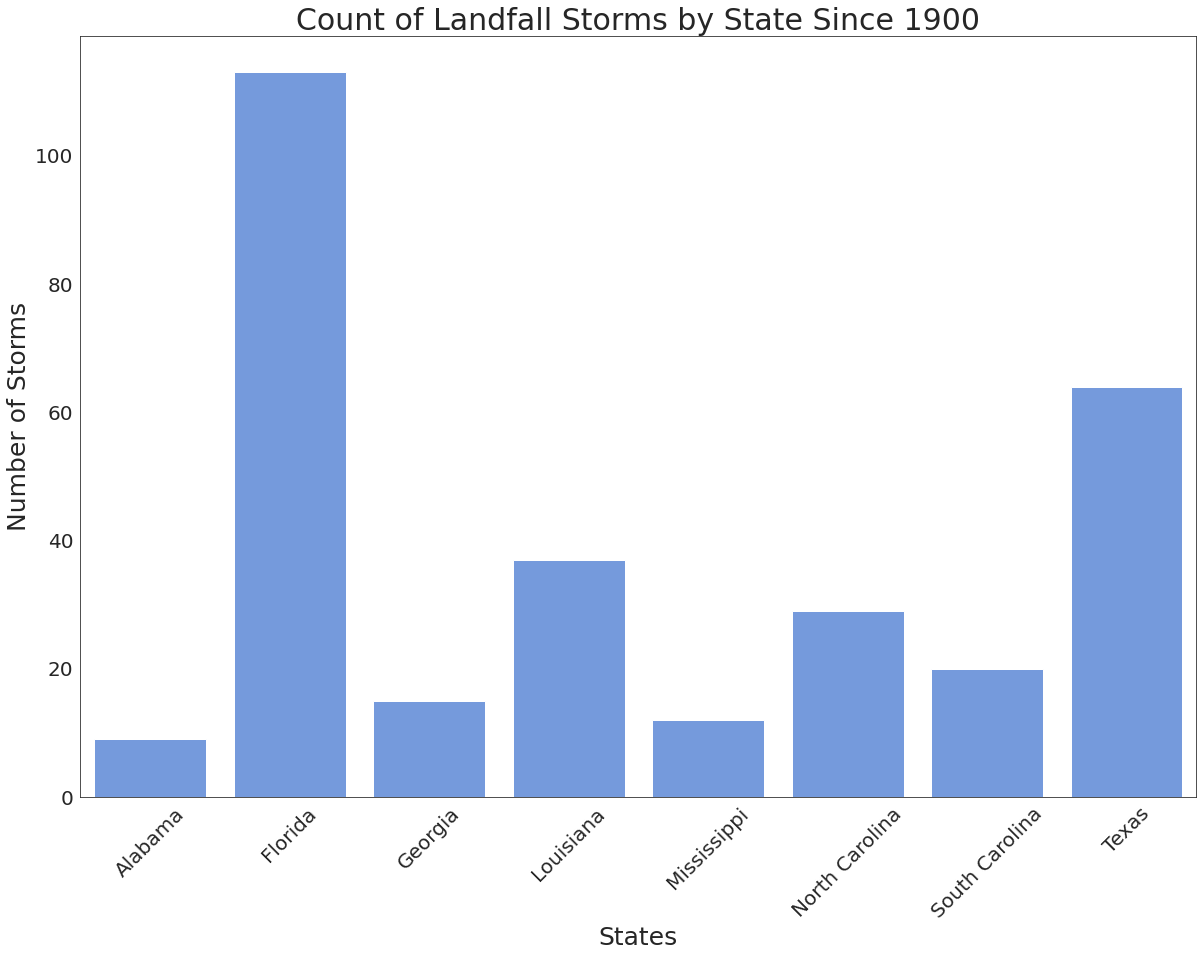

<Figure size 1440x1440 with 0 Axes>

In [50]:
plt.figure(figsize = (20,14))
sns.barplot(x=relevant['State'],y=relevant['Code'],color = 'cornflowerblue')

plt.title('Count of Landfall Storms by State Since 1900',fontsize = 30)
plt.xlabel('States', fontsize = 25)
plt.xticks(fontsize = 20, rotation=45)
plt.ylabel('Number of Storms', fontsize = 25)
plt.yticks(fontsize=20)
plt.show()
plt.savefig('CountofLandfallStorms')

In [51]:
abbr = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}

In [52]:
statecount['Abbr'] = statecount['State'].map(abbr)

onland1.groupby(['State','Code']).nunique().reset_index().groupby('State').nunique()

Code  Name  Date  Record Identifier  Storm Status  Latitude  \
State                                                                       
                 9     1     1                  2             1         1   
Acklins          1     1     1                  1             1         1   
Alabama          9     1     1                  2             1         1   
Alta Verapaz     2     1     1                  1             1         1   
Andalusia        1     1     1                  1             1         1   
...            ...   ...   ...                ...           ...       ...   
Villa Clara      6     1     1                  1             1         1   
Villalba         1     1     1                  1             1         1   
Virginia         4     1     1                  2             1         1   
Viseu            1     1     1                  1             1         1   
Yucatan          9     1     1                  1             1         1   

              Longitude  Max Sustained Wind Speed  Minumum Pressure  \
State                                                                 
                      1                         1                 2   
Acklins               1                         1                 1   
Alabama               1                         1                 2   
Alta Verapaz          1                         1                 2   
Andalusia             1                         1                 1   
...                 ...                       ...               ...   
Villa Clara           1                         1                 2   
Villalba              1                         1                 1   
Virginia              1                         1                 2   
Viseu                 1                         1                 1   
Yucatan               1                         1                 2   

              34 KT Wind Radii Max NE  ...  64 KT Size  Time Since Formation  \
State                                  ...                                     
                                    2  ...           2                     1   
Acklins                             1  ...           1                     1   
Alabama                             2  ...           2                     1   
Alta Verapaz                        1  ...           1                     1   
Andalusia                           1  ...           1                     1   
...                               ...  ...         ...                   ...   
Villa Clara                         2  ...           2                     1   
Villalba                            1  ...           1                     1   
Virginia                            1  ...           1                     1   
Viseu                               1  ...           1                     1   
Yucatan                             2  ...           2                     1   

              Category  Decade  Major Storm  Hurricane  Year  Month  Day  \
State                                                                      
                     1       1            1          1     1      1    1   
Acklins              1       1            1          1     1      1    1   
Alabama              1       1            1          1     1      1    1   
Alta Verapaz         1       1            1          1     1      1    1   
Andalusia            1       1            1          1     1      1    1   
...                ...     ...          ...        ...   ...    ...  ...   
Villa Clara          1       1            1          1     1      1    1   
Villalba             1       1            1          1     1      1    1   
Virginia             1       1            1          1     1      1    1   
Viseu                1       1            1          1     1      1    1   
Yucatan              1       1            1          1     1      1    1   

              Landfall  
State                   
        

In [53]:
fig = px.choropleth(statecount,
                    locations='Abbr',
                    color='Code',
                    color_continuous_scale='OrRd',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.show()

In [54]:
grouped = onland.groupby(['State','Category']).nunique().reset_index()
grouped = grouped[grouped['State'].isin(['Alabama','Florida','Texas','Georgia','Louisiana','North Carolina','South Carolina','Mississippi'])]

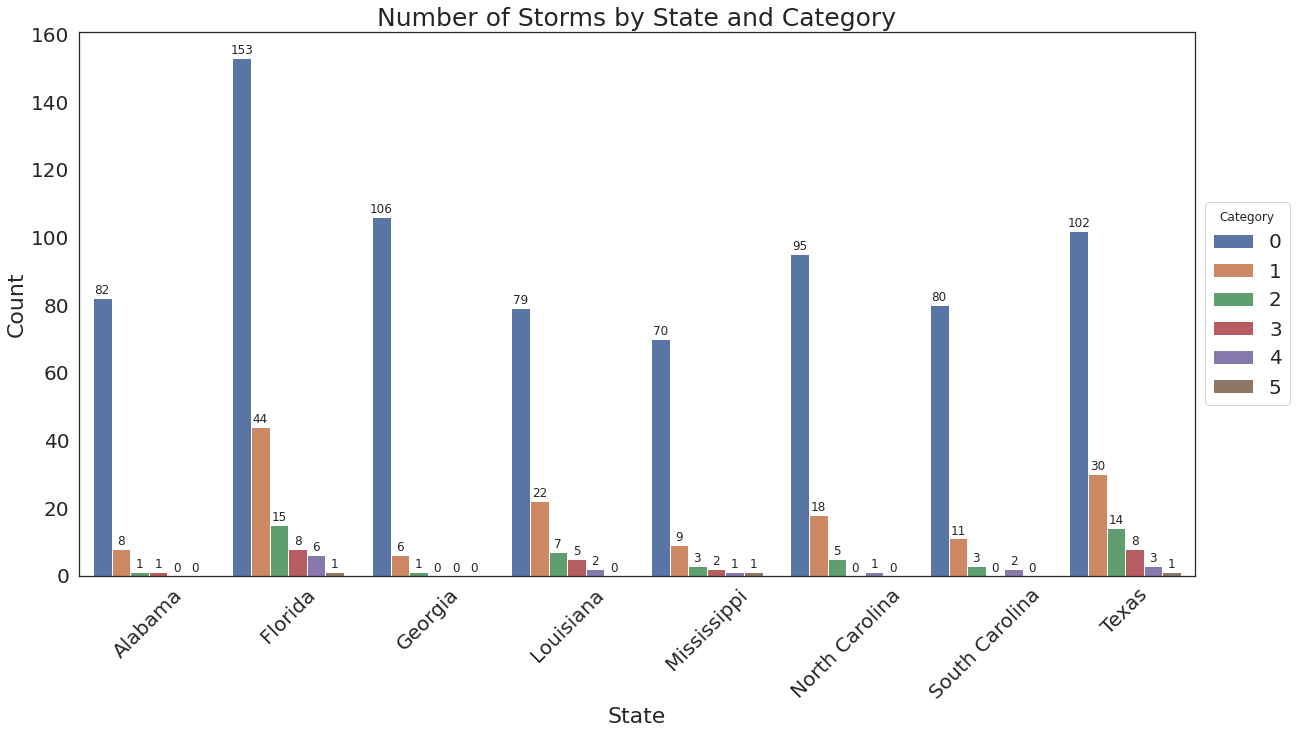

In [55]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_style('white')
fig, ax = plt.subplots()
g = sns.barplot(x='State', y='Code', hue='Category', data=grouped, ax=ax)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

g.set_xlabel('State',fontsize = 22)
plt.xticks(rotation=45, fontsize = 20)

g.set_ylabel('Count',fontsize = 22)
plt.yticks(fontsize = 20)
g.legend(title= 'Category',loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, prop={'size':20})

plt.title('Number of Storms by State and Category',fontsize = 25)
plt.show()

In [56]:
groupedhur = grouped[grouped['Category']!=0]

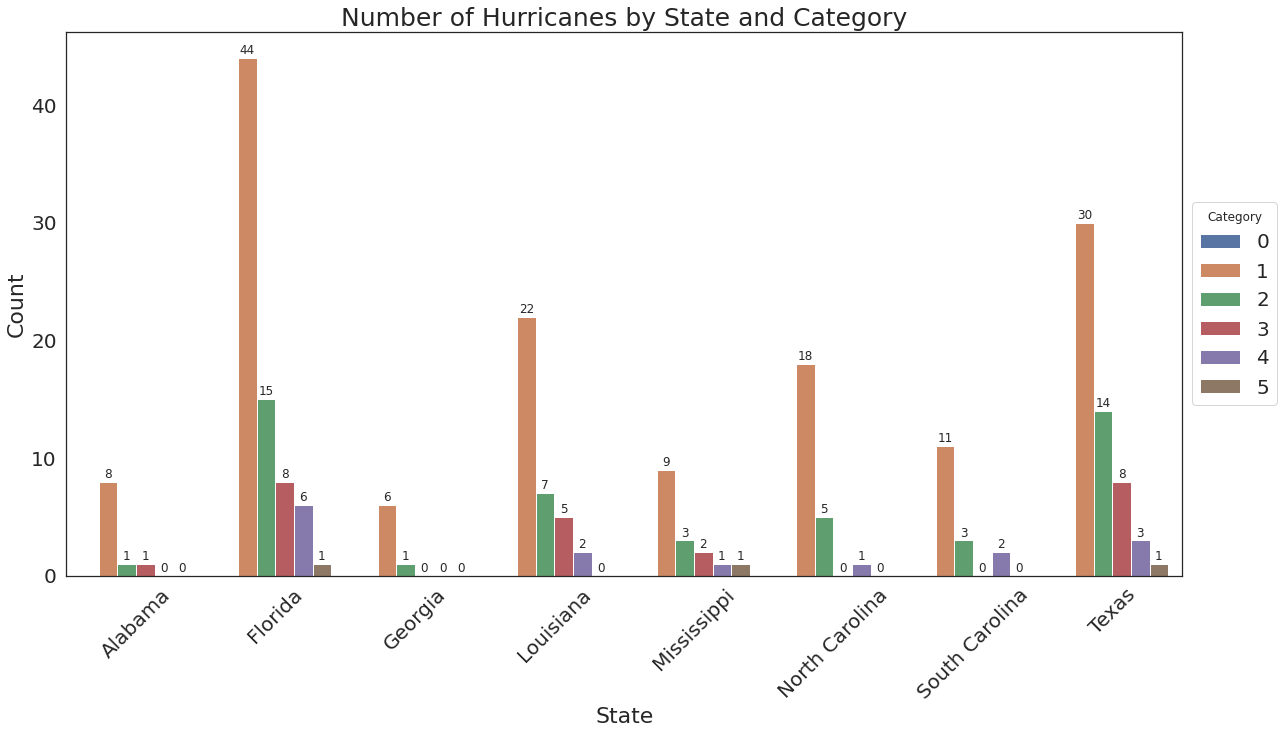

In [57]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_style('white')
fig, ax = plt.subplots()
g = sns.barplot(x='State', y='Code', hue='Category', data=groupedhur, ax=ax)

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

g.set_xlabel('State',fontsize = 22)
plt.xticks(rotation=45, fontsize = 20)

g.set_ylabel('Count',fontsize = 22)
plt.yticks(fontsize = 20)
g.legend(title= 'Category',loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, prop = {'size':20})

plt.title('Number of Hurricanes by State and Category',fontsize = 25)
plt.show()

In [58]:
top = onland[onland['State'].isin(['Florida','Texas','Georgia','Louisiana','North Carolina','Mississippi'])]
top = top[top['Max Sustained Wind Speed']>=0]
top = top[top['Record Identifier'] == 'L']

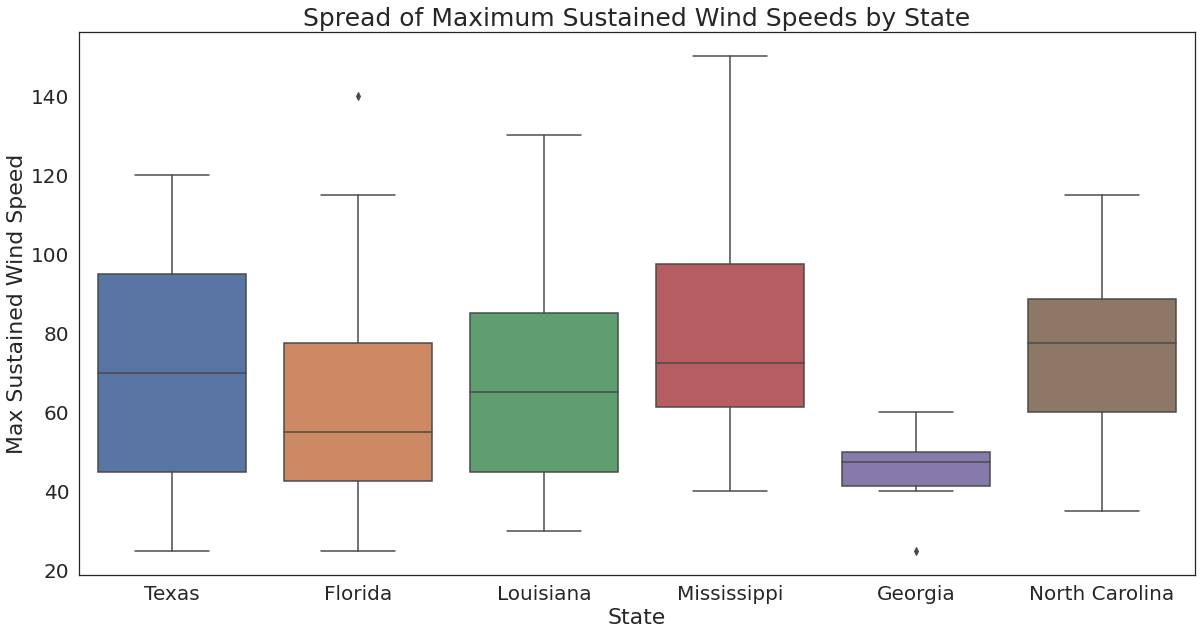

In [59]:
sns.boxplot(x = 'State',y = 'Max Sustained Wind Speed', data = top)
sns.set_style('white')
plt.xlabel('State',fontsize=22)
plt.xticks(fontsize = 20)
plt.ylabel('Max Sustained Wind Speed',fontsize=22)
plt.yticks(fontsize = 20)
plt.title('Spread of Maximum Sustained Wind Speeds by State', fontsize = 25)
plt.show()

### Landfall Bubble Map

In [60]:
onland.sort_values(by = 'Category', ascending = False)
tograph = onland.drop_duplicates('Code', keep = 'first')
tograph = tograph[tograph['Category'] != 0 ]

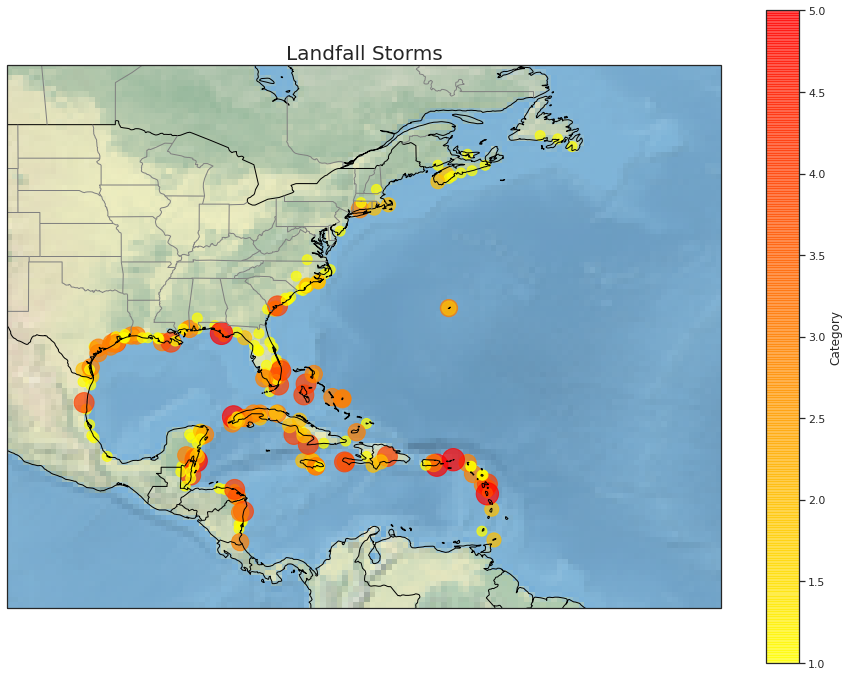

In [61]:
fig, ax = plt.subplots(figsize=(16,12), subplot_kw=dict(projection=ccrs.PlateCarree()))
# 1. Draw the map background
# To decide the range of the lat. and long., you can make use of this website:
# https://www.latlong.net/

#  The four parameters for set_extent are (x0, x1, y0, y1)
ax.set_extent([-40, -105, 5, 50])

# use underlay image to the map
ax.stock_img()

# display land and coastline
ax.add_feature(LAND)
ax.add_feature(COASTLINE)
ax.add_feature(BORDERS)

# add grid lines
#gl = ax.gridlines(draw_labels=True)

# Do not show x labels on the top of the graph
ax.xlabels_top = False
# Do not show y labels on the right side of the graph
ax.ylabels_right = False

# Apply the lat and long formatter
ax.xformatter = LONGITUDE_FORMATTER
ax.yformatter = LATITUDE_FORMATTER

states = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
ax.add_feature(states, edgecolor='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
im = ax.scatter(tograph['Longitude'], tograph['Latitude'],
                c = tograph['Category'], s=tograph['Category'].fillna(0).astype(int)*100,
          cmap='autumn_r', alpha=0.7)



# 3. create colorbar
plt.colorbar(im,label='Category')


plt.title('Landfall Storms', fontsize = 20)
plt.show()

## Category Analysis though the decades

In [62]:
hurdat['Decade_Start'] = (hurdat['Year'] // 10) * 10 

hurdat['Decade_Range'] = hurdat['Decade_Start'].astype('str') + ' - ' + \
                     (hurdat['Decade_Start'] + 9).astype('str') 

In [63]:
hurdat['Category'].cat.remove_categories([0])

9228     NaN
9229     NaN
9230     NaN
9231     NaN
9232     NaN
        ... 
52712      1
52713    NaN
52714    NaN
52715    NaN
52716    NaN
Name: Category, Length: 43489, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [64]:
hurdat2= hurdat.copy()
hurdat2['Category']= hurdat2['Category'].cat.remove_categories([0])
storms = hurdat2[~hurdat2['Category'].isnull()]
storms_sorted = storms.sort_values('Category', ascending  = False)

decadecat = storms_sorted.drop_duplicates('Code', keep = 'first')
decadecat.set_index('Date')
decadecat = decadecat.groupby(['Decade_Range','Category']).count()
decadecat = decadecat.reset_index()
hurdat['Decade_Range'].unique()

array(['1900 - 1909', '1910 - 1919', '1920 - 1929', '1930 - 1939',
       '1940 - 1949', '1950 - 1959', '1960 - 1969', '1970 - 1979',
       '1980 - 1989', '1990 - 1999', '2000 - 2009', '2010 - 2019',
       '2020 - 2029'], dtype=object)

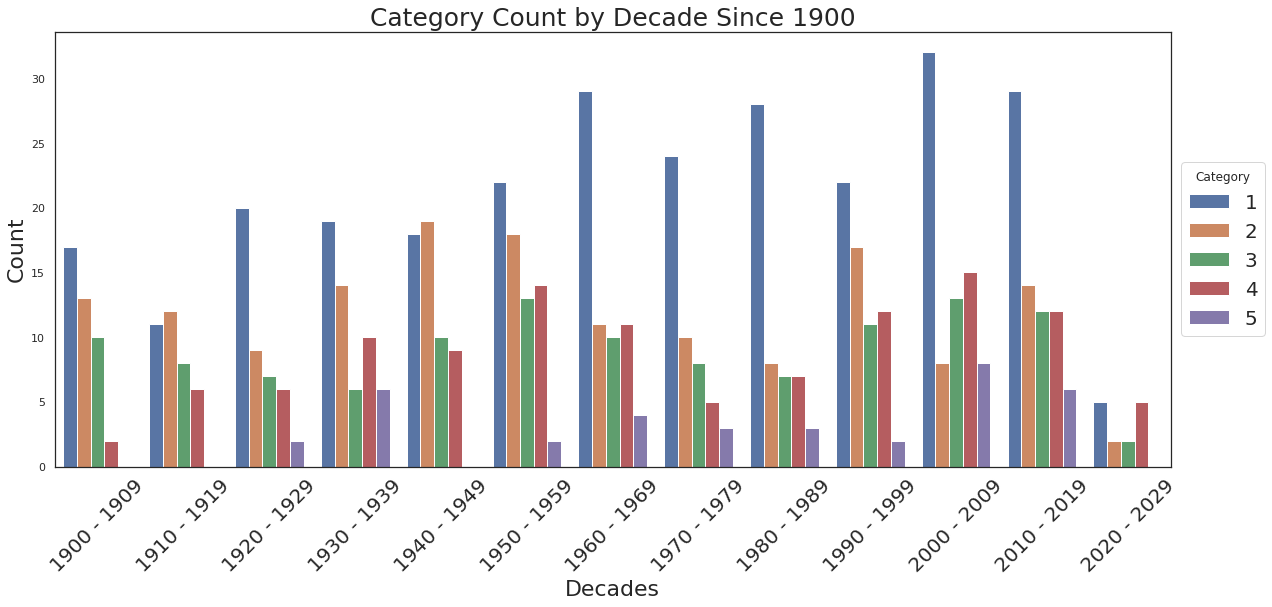

In [65]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.set_style('white')
fig, ax = plt.subplots()
g = sns.barplot(x='Decade_Range', y='Code', hue='Category', data=decadecat, ax=ax)

g.set_xlabel('Decades',fontsize = 22)
plt.xticks(rotation=45, fontsize = 20)

g.set_ylabel('Count',fontsize = 22)
plt.xticks(fontsize = 20)
g.legend(title= 'Category',loc='center left', bbox_to_anchor=(1, 0.5), ncol=1,prop= {'size':20})


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .16)
plt.title('Category Count by Decade Since 1900', fontsize=25)
plt.show()

fig.show()

## Storm paths by Quadrant

### Make Quadrants

In [66]:
hurcodes = hurdat['Code'][hurdat['Storm Status'] == 'HU']
just_hur = hurdat[hurdat['Code'].isin(hurcodes)]
#startingpoint = hurdat.drop_duplicates('Code',keep = 'first')
startingpoint = just_hur.drop_duplicates(subset='Code')
startingpoint = startingpoint[startingpoint['Year'] >= 1900]

In [67]:
q1starting = startingpoint[(startingpoint['Latitude'] > 20) & (startingpoint['Longitude'] > -70 )]
q2starting = startingpoint[(startingpoint['Latitude'] >= 20) & (startingpoint['Longitude'] <= -70 )]
q3starting = startingpoint[(startingpoint['Latitude'] <= 20) & (startingpoint['Longitude'] <= -70 )]
q4starting = startingpoint[(startingpoint['Latitude'] <= 20) & (startingpoint['Longitude'] >= -70 )]

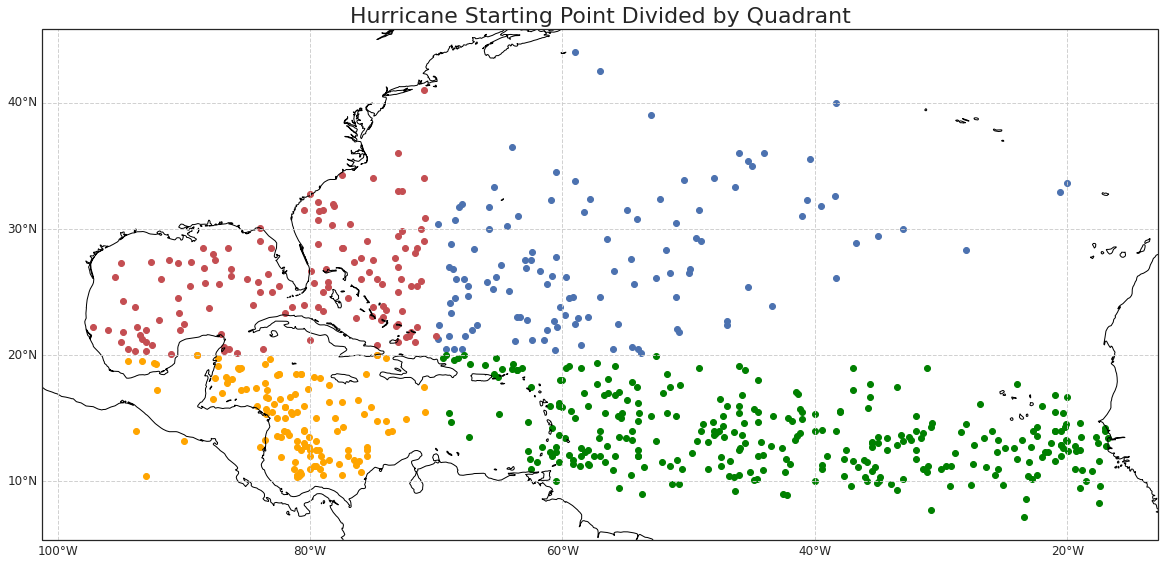

In [68]:
sns.set_style('white')
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, alpha=0.9, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.scatter(q1starting['Longitude'],q1starting['Latitude'])
plt.scatter(q2starting['Longitude'],q2starting['Latitude'],color = 'r')
plt.scatter(q3starting['Longitude'],q3starting['Latitude'],color = 'orange')
plt.scatter(q4starting['Longitude'],q4starting['Latitude'],color = 'green')
plt.title('Hurricane Starting Point Divided by Quadrant', fontsize = 22)
plt.show()

In [69]:
Q1 = hurdat.loc[hurdat.Code.isin(q1starting.Code)]
Q2 = hurdat.loc[hurdat.Code.isin(q2starting.Code)]
Q3 = hurdat.loc[hurdat.Code.isin(q3starting.Code)]
Q4 = hurdat.loc[hurdat.Code.isin(q4starting.Code)]

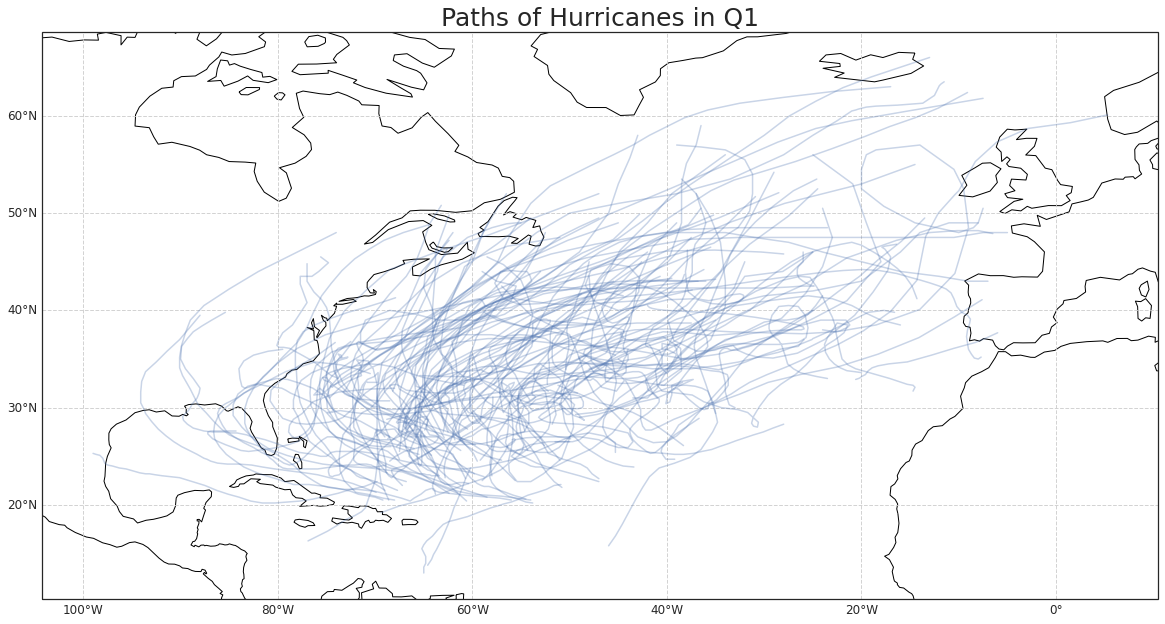

In [70]:
quadgraph(Q1,'Hurricanes','Q1','b')

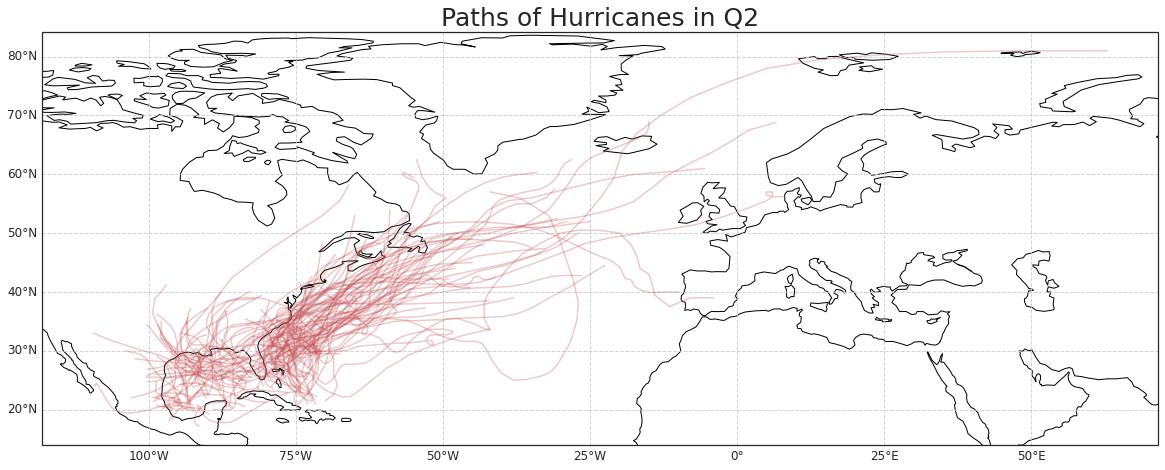

In [71]:
quadgraph(Q2,'Hurricanes','Q2','r')

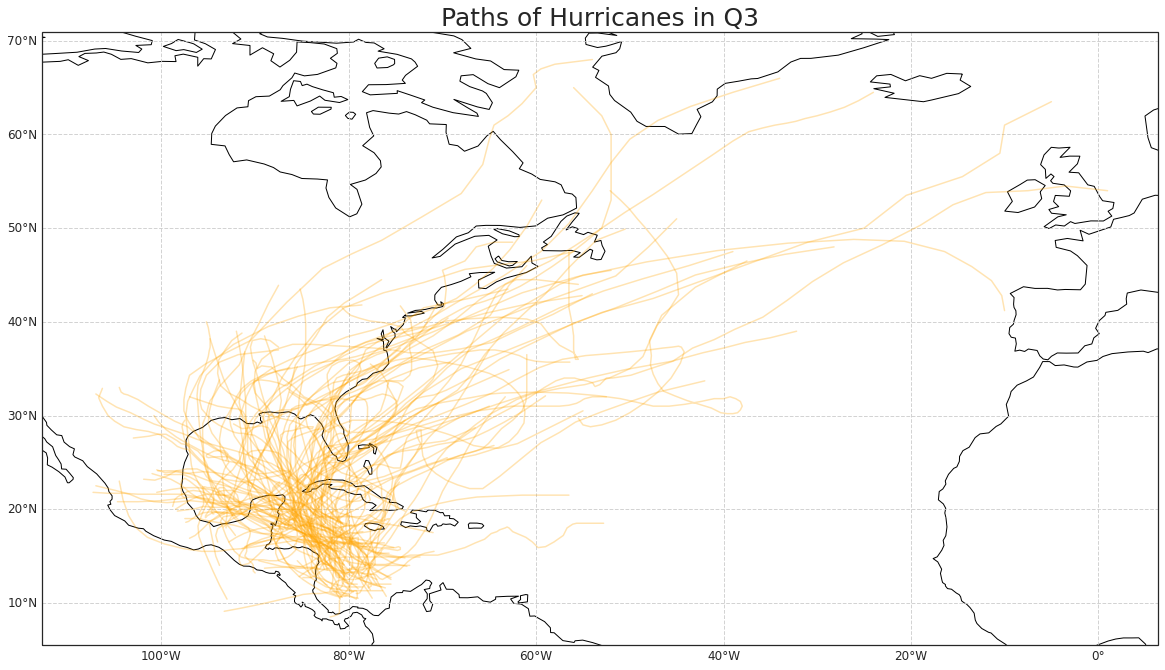

In [72]:
quadgraph(Q3,'Hurricanes','Q3','orange')

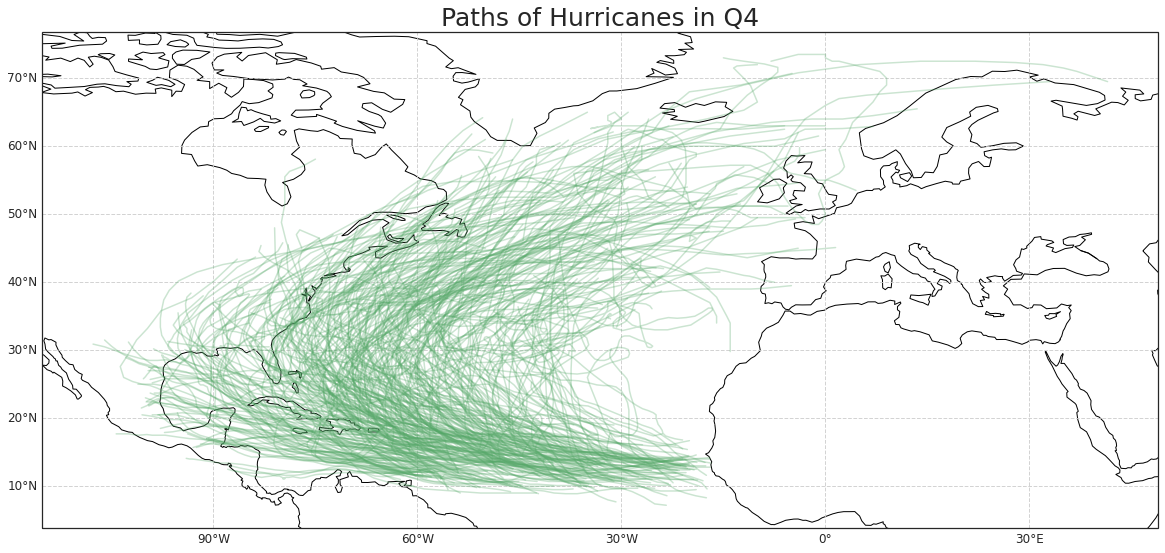

In [73]:
quadgraph(Q4,'Hurricanes','Q4','g')

<GeoAxesSubplot:title={'center':'Hurricane Starting Point Divided by Quadrant'}>

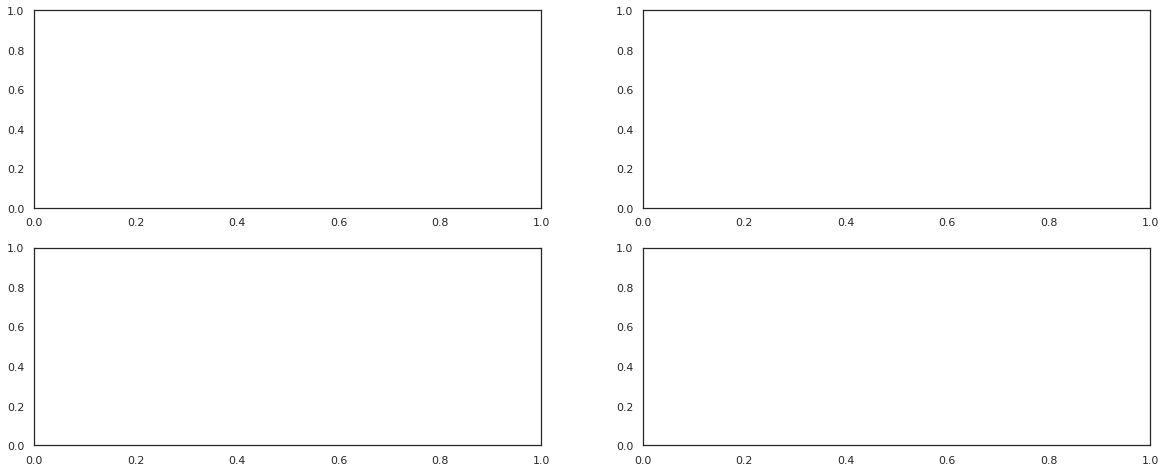

In [74]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2)
ax

## Cape Verde (and the Audacity of)

In [75]:
capeverde = startingpoint[(startingpoint['Latitude'] <= 20) & (startingpoint['Longitude'] >= -30 )]
CV = hurdat.loc[hurdat.Code.isin(capeverde.Code)]

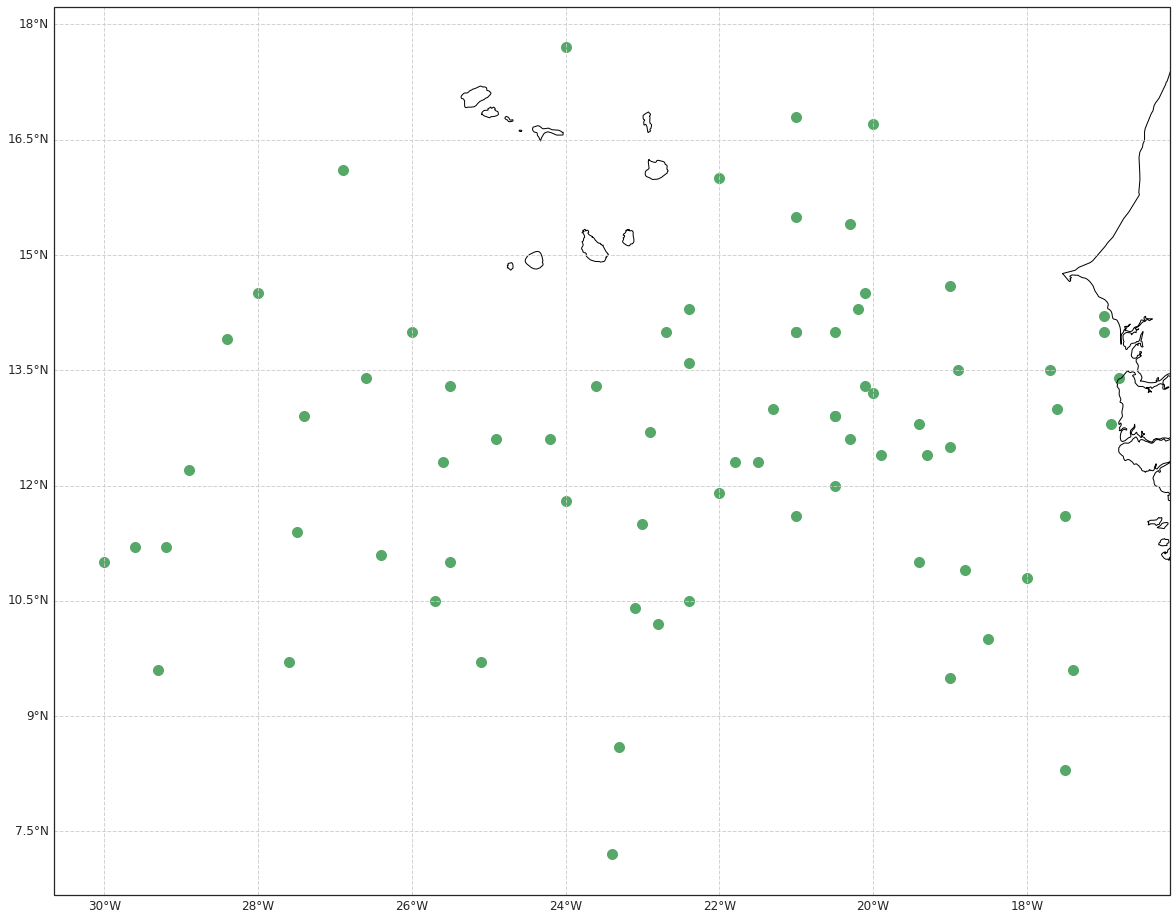

In [76]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, alpha=0.85, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.scatter(capeverde['Longitude'],capeverde['Latitude'],c='g', s = 100)


In [77]:
CVlandfall = CV.loc[CV.Code.isin(onland.Code)]
CVsea = CV.loc[~CV.Code.isin(onland.Code)]
CVHur = CV.loc[CV.Code.isin(just_hur.Code)]
CVCat= CV.sort_values(by = 'Category').drop_duplicates('Code',keep = 'last').groupby('Category').count().reset_index()[1:]

In [78]:
NotCV = just_hur.loc[~just_hur.Code.isin(CV)]
NotCVCat = NotCV.sort_values(by = 'Category').drop_duplicates('Code',keep = 'last').groupby('Category').count().reset_index()[1:]

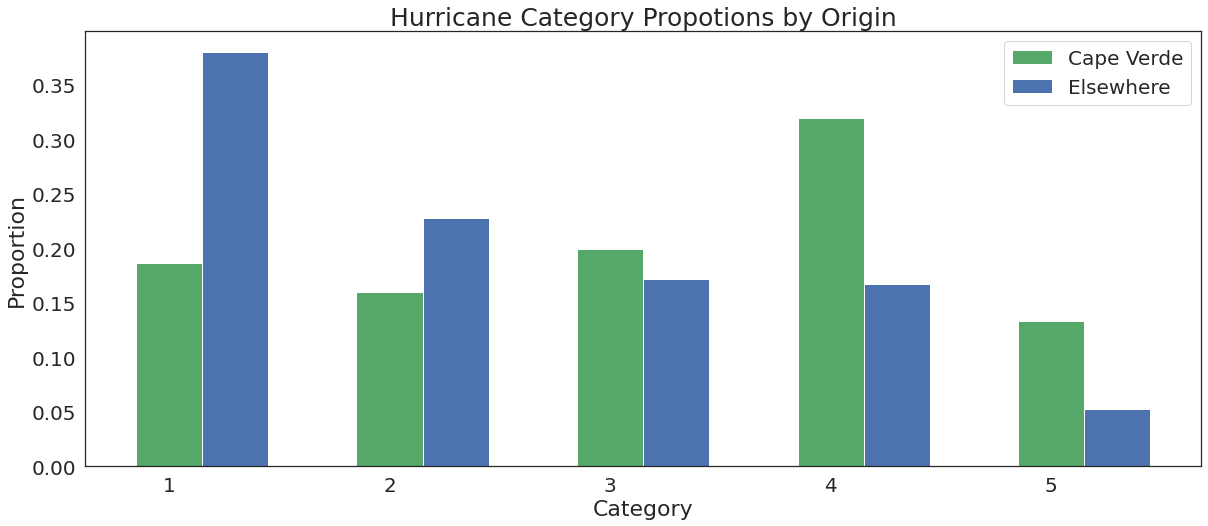

In [79]:
width = 0.3  
plt.bar(x=CVCat['Category'], height = CVCat['Code']/sum(CVCat['Code']),width = width, label = 'Cape Verde', color = 'g')
plt.bar(x=NotCVCat['Category'].astype(int) + width, height = NotCVCat['Code']/sum(NotCVCat['Code']),width = width, label= 'Elsewhere')
plt.xlabel('Category', fontsize = 22)
plt.xticks(fontsize = 20)
plt.ylabel('Proportion', fontsize = 22)
plt.yticks(fontsize = 20)
plt.legend(prop={'size':20})

plt.title('Hurricane Category Propotions by Origin', fontsize = 25)

plt.show()